In [8]:
import pandas as pd 
import pymc as pm
import numpy as np
import arviz as az

In [9]:
foxes = pd.read_csv('./data/foxes.csv', sep=';')
foxes.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [75]:
def standarize(series):
    return (series - np.mean(series)) / np.std(series)

weights = standarize(foxes.weight)
area = standarize(foxes.area)
avgfood = standarize(foxes.avgfood)
groupsize = standarize(foxes.groupsize)

In [76]:
#6H3 -> total causal influence of area on weight
with pm.Model() as m1:
    area_var = pm.MutableData("area", area)
    beta_area= pm.Normal('beta_area', 0, 1)
    alpha = pm.Normal('alpha', 5, 0.5) # 5kg is known to be avg england fox, haven't looked at this data.
    mu = pm.Deterministic('mu', alpha + beta_area * area_var)
    sigma = pm.Exponential('sigma',1)
    w = pm.Normal('w', mu=mu, sigma=sigma, observed=weights)  

In [77]:
with m1:
    prior_m1 = pm.sample_prior_predictive();

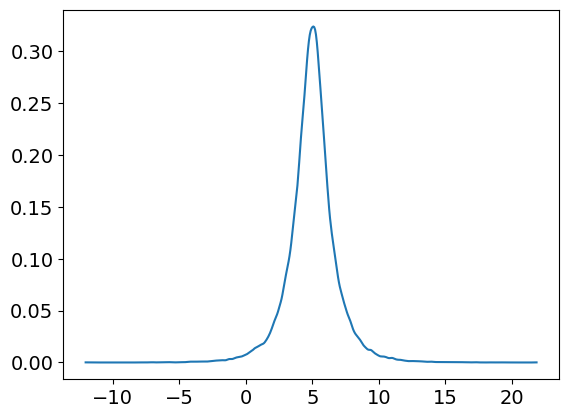

In [78]:
az.plot_kde(prior_m1.prior_predictive['w'].values);

#az.plot_ppc(prior_m1, coords={'obs_id': ['ANOKA', 'BELTRAMI']}, flatten=[])


In [79]:
with m1:
    posterior_m1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_area, alpha, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


In [80]:
az.summary(posterior_m1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_area,0.020,0.096,-0.159,0.199,0.001,0.001,10839.0,6221.0,1.0
alpha,0.179,0.098,-0.008,0.356,0.001,0.001,8722.0,5360.0,1.0
sigma,1.031,0.071,0.900,1.165,0.001,0.001,9060.0,5818.0,1.0
mu[0],0.133,0.235,-0.304,0.572,0.002,0.002,10353.0,5962.0,1.0
mu[1],0.133,0.235,-0.304,0.572,0.002,0.002,10353.0,5962.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[111],0.169,0.107,-0.029,0.370,0.001,0.001,8867.0,5904.0,1.0
mu[112],0.169,0.107,-0.029,0.370,0.001,0.001,8867.0,5904.0,1.0
mu[113],0.151,0.162,-0.160,0.447,0.002,0.001,9917.0,6077.0,1.0
mu[114],0.151,0.162,-0.160,0.447,0.002,0.001,9917.0,6077.0,1.0


Text(0.5, 0, 'standarized area')

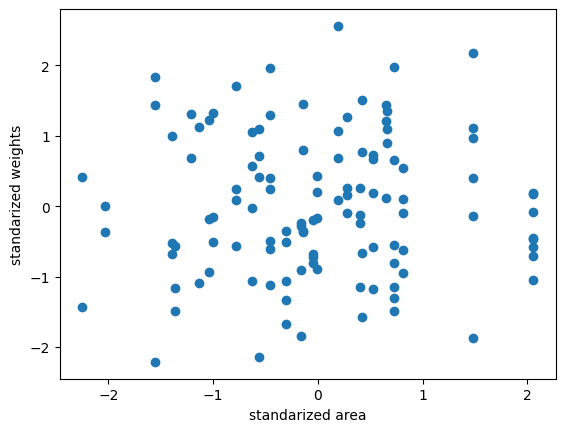

In [81]:
#az.hdi()

plt.scatter(area, weights)
plt.ylabel('standarized weights')
plt.xlabel('standarized area')

In [93]:
#posterior_m1.posterior['alpha'] + posterior_m1.posterior['beta_area'] * area

with m1:
    pm.set_data({"area": np.linspace(-3, 3, 100)})
    ppc = pm.sample_posterior_predictive(posterior_m1, var_names=['w', 'mu'])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


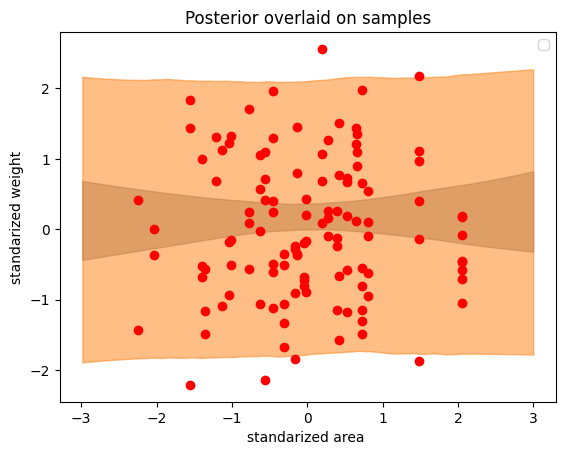

In [102]:
_, ax = plt.subplots()

x = np.linspace(-3, 3, 100)
ax.set_title("Posterior overlaid on samples")

# poster parameters
az.plot_hdi(x, ppc.posterior_predictive["mu"], ax=ax, color="grey")

az.plot_hdi(
    x,
    ppc.posterior_predictive["w"],
    ax=ax,
)

ax.scatter(area, weights, c="red")
plt.xlabel("standarized area ")
plt.ylabel("standarized weight")
plt.legend();

Above we have HDI for weights and mean weight

So adding area doesn't seem to move weight distribution.

6H4 causal impact of adding food to a territory.

Adding groupsize would not help us measure the effect of adding food, since it is going to capture the effect of food on group on weight

In [117]:

with pm.Model() as m2:
#    area_var = pm.MutableData("area", area) #keeping it just as excercise, it should be 0
    food_var = pm.MutableData("food", avgfood)
    beta_food =pm.Normal('beta_food', 0, 1)
    alpha = pm.Normal('alpha', 5, 0.5) # 5kg is known to be avg england fox, haven't looked at this data.
    mu = pm.Deterministic('mu', alpha + beta_food * food_var)
    sigma = pm.Exponential('sigma',1)
    w = pm.Normal('w', mu=mu, sigma=sigma, observed=weights)  

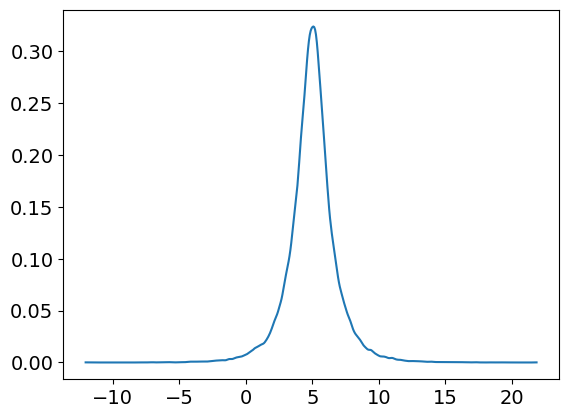

In [118]:
az.plot_kde(prior_m1.prior_predictive['w'].values);


In [119]:
with m2:
    posterior_m2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_food, alpha, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


In [120]:
az.summary(posterior_m2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_food,-0.024,0.093,-0.204,0.145,0.001,0.001,10884.0,5637.0,1.0
alpha,0.177,0.098,-0.008,0.360,0.001,0.001,9977.0,5667.0,1.0
sigma,1.031,0.070,0.900,1.163,0.001,0.001,9796.0,6370.0,1.0
mu[0],0.224,0.204,-0.174,0.598,0.002,0.002,10868.0,6208.0,1.0
mu[1],0.224,0.204,-0.174,0.598,0.002,0.002,10868.0,6208.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[111],0.187,0.105,-0.016,0.378,0.001,0.001,10231.0,6150.0,1.0
mu[112],0.187,0.105,-0.016,0.378,0.001,0.001,10231.0,6150.0,1.0
mu[113],0.219,0.188,-0.137,0.574,0.002,0.002,10834.0,6389.0,1.0
mu[114],0.219,0.188,-0.137,0.574,0.002,0.002,10834.0,6389.0,1.0


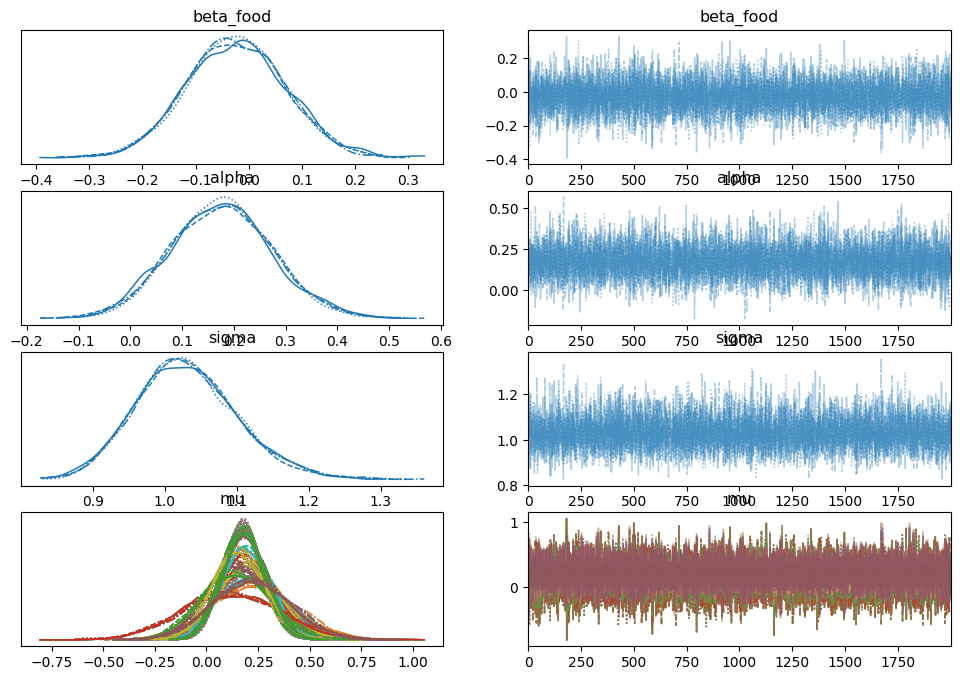

In [121]:
az.plot_trace(posterior_m2);

In [124]:
with m2:
    pm.set_data({"food": np.linspace(-3, 3, 100)})
    ppcm2 = pm.sample_posterior_predictive(posterior_m2, var_names=['w', 'mu'])

So the food seems to have a negative effect on weight, but the posterior is too wide.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


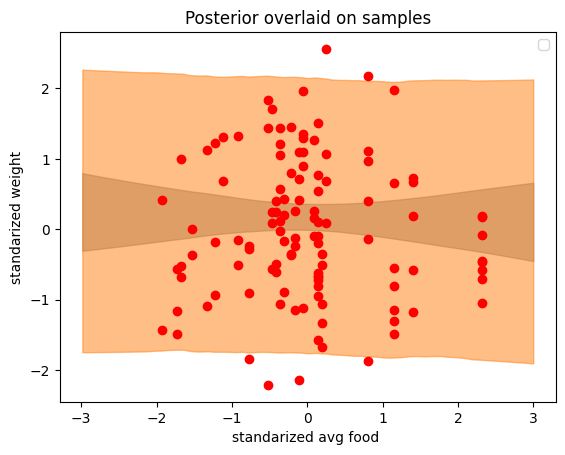

In [125]:
_, ax = plt.subplots()

x = np.linspace(-3, 3, 100)
ax.set_title("Posterior overlaid on samples")

# poster parameters
az.plot_hdi(x, ppcm2.posterior_predictive["mu"], ax=ax, color="grey")

az.plot_hdi(
    x,
    ppcm2.posterior_predictive["w"],
    ax=ax,
)

ax.scatter(avgfood, weights, c="red")
plt.xlabel("standarized avg food ")
plt.ylabel("standarized weight")
plt.legend();

In [126]:
with pm.Model() as m3:
#    area_var = pm.MutableData("area", area) #keeping it just as excercise, it should be 0
    food_var = pm.MutableData("food", avgfood)
    beta_food =pm.Normal('beta_food', 0, 1)
    beta_groupsize = pm.Normal('beta_groupsize',0,1)
    alpha = pm.Normal('alpha', 5, 0.5) # 5kg is known to be avg england fox, haven't looked at this data.
    mu = pm.Deterministic('mu', alpha + beta_food * food_var + beta_groupsize * groupsize)
    sigma = pm.Exponential('sigma',1)
    w = pm.Normal('w', mu=mu, sigma=sigma, observed=weights)  

In [127]:
with m3:
    posterior_m3 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_food, beta_groupsize, alpha, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


In [128]:
az.summary(posterior_m3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_food,0.583,0.204,0.189,0.954,0.003,0.002,3659.0,4007.0,1.0
beta_groupsize,-0.681,0.203,-1.067,-0.300,0.003,0.002,3562.0,4084.0,1.0
alpha,0.160,0.093,-0.006,0.339,0.001,0.001,6311.0,4743.0,1.0
sigma,0.978,0.068,0.853,1.108,0.001,0.001,6666.0,5138.0,1.0
mu[0],0.074,0.201,-0.312,0.449,0.002,0.002,6810.0,6272.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[111],0.071,0.104,-0.127,0.259,0.001,0.001,6062.0,5698.0,1.0
mu[112],0.071,0.104,-0.127,0.259,0.001,0.001,6062.0,5698.0,1.0
mu[113],-0.252,0.227,-0.672,0.195,0.003,0.002,4960.0,5467.0,1.0
mu[114],-0.252,0.227,-0.672,0.195,0.003,0.002,4960.0,5467.0,1.0


array([[<AxesSubplot:title={'center':'beta_food'}>,
        <AxesSubplot:title={'center':'beta_food'}>],
       [<AxesSubplot:title={'center':'beta_groupsize'}>,
        <AxesSubplot:title={'center':'beta_groupsize'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

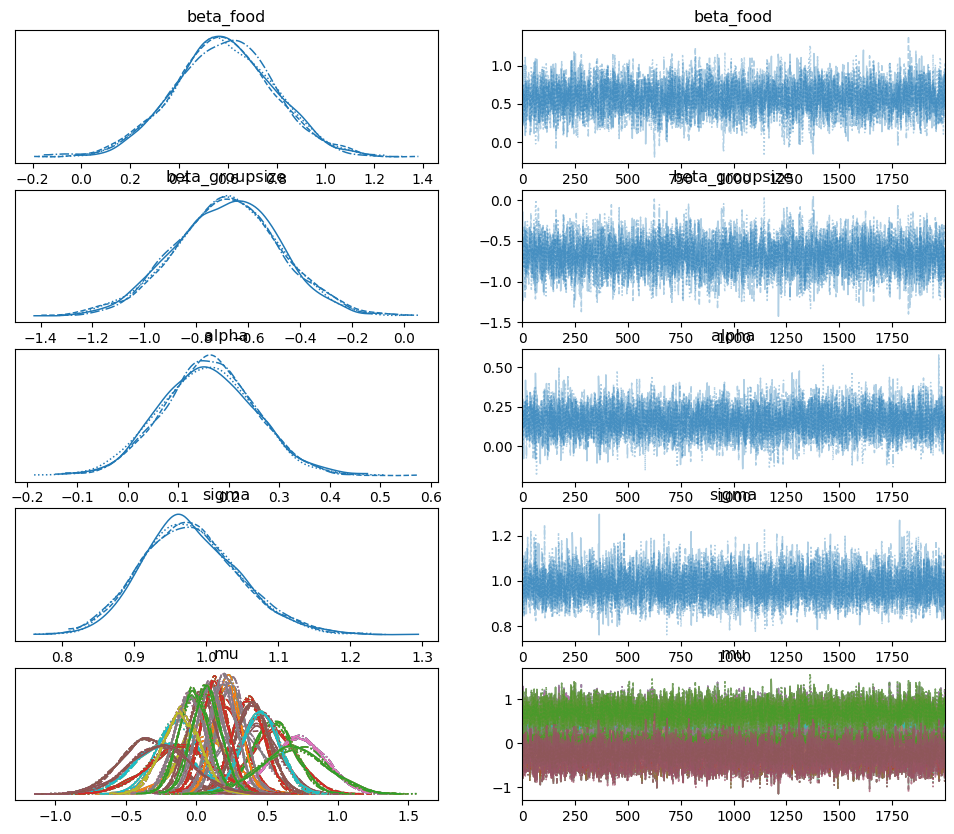

In [129]:
az.plot_trace(posterior_m3)

Agregar area al calcular avgfood-> weight nos va a complicar el estimado (si bien no es un backdoor) al quitarnos precision.